## Table of Contents
- [Loading X_train, X_val and X_test](#section1)
- [Add spatial lag features](#section2)
- [Encoding categorical features](#section3)
- [KNN](#section4)
- [Distanceband](#section5)
- [ROOK](#section6)
- [Predictions](#section7)
- [Classification_report + metrics ](#section8)
- [Province analysis (error count)](#section9)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy.stats

from sklearn.neighbors import NearestNeighbors
%matplotlib inline
import geopandas as gpd
import torch
import joblib
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score,confusion_matrix, classification_report
np.random.seed(10)
from libpysal import weights

# import self written function
from functions_spatialmodels import Objective_knn, Objective_rf, Objective_xgb, Objective_tabnet, all_metrics, predict, conf_matrix
from functions_spatialmodels import spatial_lag_distance_band, spatial_lag_knn, spatial_lag_queen, spatial_lag_rook, encoding_categorical_features, scaling_features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

<a id='section1'></a>
# Loading X_train, X_val and X_test
[Back to Table of Contents](#Table-of-Contents)

In [2]:
X_test = pd.read_csv("X_test.csv", index_col=0)
X_train_split= pd.read_csv("X_train_split.csv", index_col=0)
X_val= pd.read_csv("X_val.csv",  index_col=0)

In [3]:
# Source: https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/gegevens-per-postcode
# extracting geometry code of each postcode
gpkg = gpd.read_file("cbs_pc4_2022_v1.gpkg")
gpkg["postcode4"]= gpkg["postcode4"].astype("int64")
gpkg = gpkg[["postcode4", "geometry"]]
gpkg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   postcode4  4070 non-null   int64   
 1   geometry   4070 non-null   geometry
dtypes: geometry(1), int64(1)
memory usage: 63.7 KB


<a id='section2'></a>
# Add spatial lag features 
[Back to Table of Contents](#Table-of-Contents)

In [4]:
lst =["SurroundingAddressDensity","AvgDistToTrainStation","NumBusStops",
    'RoadNetworkDensity',"AvgDistToSupermarket",
   "NofBusinessEstablishments"] # extract built environment features for spatial analysis

In [5]:
X_train_KNN8 = spatial_lag_knn(gpkg, X_train_split, 8, lst, "LagKNN8")
X_test_KNN8 = spatial_lag_knn(gpkg, X_test, 8, lst, "LagKNN8")
X_val_KNN8 = spatial_lag_knn(gpkg, X_val, 8, lst, "LagKNN8")


In [6]:
X_train_rook = spatial_lag_rook(gpkg, X_train_split, lst, "LagRook")
X_test_rook = spatial_lag_rook(gpkg, X_test, lst, "LagRook")
X_val_rook = spatial_lag_rook(gpkg, X_val, lst, "LagRook")


In [7]:
X_train_distance_band10000 = spatial_lag_distance_band(gpkg, X_train_split, lst, "LagDistanceBand10000", 10000)
X_test_distance_band10000 = spatial_lag_distance_band(gpkg, X_test, lst, "LagDistanceBand10000", 10000)
X_val_distance_band10000 = spatial_lag_distance_band(gpkg, X_val, lst, "LagDistanceBand10000", 10000)


In [31]:
# https://onlinelibrary-wiley-com.tilburguniversity.idm.oclc.org/doi/10.1111/tgis.12729
geo_X_train_rook = X_train_rook[["geometry"]]
geo_X_test_rook = X_test_rook[["geometry"]]
geo_X_val_rook= X_val_rook[["geometry"]]

geo_X_train_KNN8  = X_train_KNN8[["geometry"]]
geo_X_test_KNN8 = X_test_KNN8[["geometry"]]
geo_X_val_KNN8 = X_val_KNN8[["geometry"]]


geo_X_train_distance_band10000 = X_train_distance_band10000[["geometry"]]
geo_X_test_distance_band10000 = X_test_distance_band10000[["geometry"]]
geo_X_val_distance_band10000 = X_val_distance_band10000[["geometry"]]

In [48]:
geo_X_train_rook.to_csv("geo_X_train_rook.csv", index=False)
geo_X_test_rook.to_csv("geo_X_test_rook.csv", index=False)
geo_X_val_rook.to_csv("geo_X_val_rook.csv", index=False)

geo_X_train_KNN8.to_csv("geo_X_train_KNN8.csv", index=False)
geo_X_test_KNN8.to_csv("geo_X_test_KNN8.csv", index=False)
geo_X_val_KNN8.to_csv("geo_X_val_KNN8.csv", index=False)

geo_X_train_distance_band10000.to_csv("geo_X_train_distance_band10000.csv", index=False)
geo_X_train_distance_band10000.to_csv("geo_X_train_distance_band10000.csv", index=False)
geo_X_train_distance_band10000.to_csv("geo_X_train_distance_band10000.csv", index=False)



In [8]:
# drop features not needed 
for features in ["UniqueIdentifier", "HomePostalCode", 'Residential Municipality',"geometry", "ResidentialProvince", 
                ]: 
    X_train_distance_band10000.drop([features], inplace=True, axis=1)
    X_train_rook.drop([features], inplace=True, axis=1)
    X_train_KNN8.drop([features], inplace=True, axis=1)
    
    X_val_distance_band10000.drop([features], inplace=True, axis=1)
    X_val_rook.drop([features], inplace=True, axis=1)
    X_val_KNN8.drop([features], inplace=True, axis=1)
    
    X_test_distance_band10000.drop([features], inplace=True, axis=1)
    X_test_rook.drop([features], inplace=True, axis=1)
    X_test_KNN8.drop([features], inplace=True, axis=1)


<a id='section3'></a>
# Encoding categorical features
[Back to Table of Contents](#Table-of-Contents)

In [9]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder

X_train_KNN8 , X_val_KNN8, X_test_KNN8= encoding_categorical_features(X_train_KNN8 , X_val_KNN8, X_test_KNN8)
X_train_rook, X_val_rook, X_test_rook = encoding_categorical_features(X_train_rook, X_val_rook, X_test_rook)
X_train_distance_band10000, X_val_distance_band10000, X_test_distance_band10000 = encoding_categorical_features(X_train_distance_band10000, X_val_distance_band10000, X_test_distance_band10000)



In [10]:
ordinal_features = ["AgeClass","HouseholdSize", "DisposableIncome","FrequencyOfUseOfNonEelectricBicycle", "FrequencyOfWalkingOutdoors",
                    "NumberOfCarsInHousehold",  "EducationLevel","FrequencyOfUseCcarAsAPassenger"]
numeric_features = [ "TotalTravelDuration", "DepartureTime","NumberOfTripLegs"
                    , "NumBusStops", 'RoadNetworkDensity','AvgDistToTrainStation',"TripLegDistance","N.OFHouseholdMemberUnd6",
    'AvgDistToSupermarket', 'NofBusinessEstablishments', 'SurroundingAddressDensity', "LatitudeLiving", "LongitudeLiving"]
categorical_features = ["TripPurpose","WorkCommuteReimbursement", ]
binary_features = ["Gender","License", "Weekday", "ElectriBicycleIHousehold"]
pca_features = ["PCA_dr_wl_cl_duration_2","PCA_dr_wl_cl_duration_1", "PCA_dr_wl_cl_duration_3"]


lag_knn8 = ["SurroundingAddressDensity_LagKNN8",  "AvgDistToTrainStation_LagKNN8",   "NumBusStops_LagKNN8",
    "RoadNetworkDensity_LagKNN8",   "AvgDistToSupermarket_LagKNN8",  "NofBusinessEstablishments_LagKNN8"]

lag_dist10000= ['SurroundingAddressDensity_LagDistanceBand10000', 'AvgDistToTrainStation_LagDistanceBand10000',
    'NumBusStops_LagDistanceBand10000',   'RoadNetworkDensity_LagDistanceBand10000',
    'AvgDistToSupermarket_LagDistanceBand10000',   'NofBusinessEstablishments_LagDistanceBand10000']


lag_rook = ["SurroundingAddressDensity_LagRook", "AvgDistToTrainStation_LagRook", "NumBusStops_LagRook",
    "RoadNetworkDensity_LagRook",  "AvgDistToSupermarket_LagRook",   "NofBusinessEstablishments_LagRook"]


In [11]:
# scaling features
# X_train_split, X_val, X_test, ordinal_features, numeric_features, categorical_features, binary_features, lag_features, pca_features

X_train_KNN8 , X_val_KNN8, X_test_KNN8, all_feature_namesKNN8, scaler = scaling_features(X_train_KNN8 , X_val_KNN8, X_test_KNN8, 
                                            ordinal_features, numeric_features, categorical_features, binary_features, lag_knn8, pca_features)

X_train_rook, X_val_rook, X_test_rook, all_feature_namesrook, scaler = scaling_features(X_train_rook, X_val_rook, X_test_rook, 
                                            ordinal_features, numeric_features, categorical_features, binary_features, lag_rook, pca_features)

X_train_distance_band10000, X_val_distance_band10000, X_test_distance_band10000, all_feature_dist10000, scaler= scaling_features(X_train_distance_band10000,
                                              X_val_distance_band10000, X_test_distance_band10000, 
                                            ordinal_features, numeric_features, categorical_features, binary_features, lag_dist10000, pca_features )
                                                                              

In [12]:
len(all_feature_dist10000)

41

In [13]:
# load the y_data (encoded)
y_train_split = np.loadtxt('y_train_split_encoded.txt', dtype=int)
y_val = np.loadtxt('y_val_encoded.txt', dtype=int)
y_test = np.loadtxt('y_test_encoded.txt', dtype=int)


In [15]:
# rescale features for explainable ai
X_train_unscaled_numeric = scaler.inverse_transform(X_train_distance_band10000[:, :len(numeric_features)])  
X_val_unscaled_numeric = scaler.inverse_transform(X_val_distance_band10000[:, :len(numeric_features)])
X_test_unscaled_numeric = scaler.inverse_transform(X_test_distance_band10000[:, :len(numeric_features)])

In [16]:
# unscaled X_rook for shap analysis 
len_unscaled_numeric = len(numeric_features)

# unscaled X_rook for shap analysis 
len_unscaled_numeric = len(numeric_features)



X_test_dist10000_un = np.concatenate([
    X_test_unscaled_numeric,
    X_test_distance_band10000[:, len_unscaled_numeric:],  
], axis=1)

X_train_dist10000_un = np.concatenate([
    X_train_unscaled_numeric,
    X_train_distance_band10000[:, len_unscaled_numeric:],
], axis=1)

X_val_dist10000_un = np.concatenate([
    X_val_unscaled_numeric,
    X_val_distance_band10000[:, len_unscaled_numeric:],  
], axis=1)



In [17]:
# best model
np.save("X_train_distance_band10000", X_train_distance_band10000)
np.save("X_test_distance_band10000", X_test_distance_band10000)
np.save("X_val_distance_band10000",X_val_distance_band10000)

np.save("all_feature_dist10000", all_feature_dist10000)

In [18]:
# save unscaled features
np.save("X_train_dist10000_unn", X_train_dist10000_un)
np.save("X_val_dist10000_un", X_val_dist10000_un)
np.save("X_test_dist10000_un", X_test_dist10000_un)

<a id='section4'></a>
# KNN
[Back to Table of Contents](#Table-of-Contents)

In [ ]:
import optuna
from optuna import Trial
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
random_state = 0

from sklearn.ensemble import RandomForestClassifier
from optuna.pruners import SuccessiveHalvingPruner

from xgboost import XGBClassifier
import torch
from sklearn.metrics import f1_score
from pytorch_tabnet.tab_model import TabNetClassifier

from functions_spatialmodels import Objective_knn, Objective_rf, Objective_xgb, Objective_tabnet, all_metrics, predict, conf_matrix

# model:KNN_KNN8

In [22]:
import optuna
import joblib

random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_knn(trial, X_train_KNN8, y_train_split, X_val_KNN8, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_knn_KNN8.pkl')

best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 19:52:42,272] A new study created in memory with name: no-name-8a1e2d7e-1bd9-4f7b-a5ef-4bbb71a85d15
[I 2024-04-28 19:52:47,554] Trial 0 finished with value: 0.5478816207638229 and parameters: {'n_neighbors': 281, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 0 with value: 0.5478816207638229.
[I 2024-04-28 19:56:28,976] Trial 1 finished with value: 0.5461956828022773 and parameters: {'n_neighbors': 293, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.5478816207638229.
[I 2024-04-28 20:00:04,549] Trial 2 finished with value: 0.5553697980109764 and parameters: {'n_neighbors': 259, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 2 with value: 0.5553697980109764.
[I 2024-04-28 20:05:25,394] Trial 3 finished with value: 0.5970512296692192 and parameters: {'n_neighbors': 252, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'ball_tree'}. Best is tr

Best Score:  0.6004400047039853
Best Params: 
  n_neighbors: 251
  weights: distance
  metric: manhattan
  algorithm: ball_tree


# model:RF_KNN8

In [40]:
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_rf(trial, X_train_KNN8, y_train_split, X_val_KNN8, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_rf_KNN8.pkl')


best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-29 17:44:34,230] A new study created in memory with name: no-name-20c76ac7-f6a3-4f26-9dce-b02f47fcf4b0
[I 2024-04-29 17:44:34,308] Trial 0 finished with value: 0.5125151899321583 and parameters: {'n_estimators': 1, 'max_depth': 4, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.5125151899321583.
[I 2024-04-29 17:44:34,942] Trial 1 finished with value: 0.6945437358687714 and parameters: {'n_estimators': 2, 'max_depth': 22, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6945437358687714.
[I 2024-04-29 17:44:36,254] Trial 2 finished with value: 0.6999306622527346 and parameters: {'n_estimators': 1, 'max_depth': 15, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 2 with value: 0.6999306622527346.
[I 2024-04-29 17:44:47,832] Trial 3 finished with value: 0.6962427978219745 and parameter

Best Score:  0.7584561075898516
Best Params: 
  n_estimators: 286
  max_depth: 40
  min_samples_leaf: 9
  max_features: None
  bootstrap: True
  criterion: entropy


https://link-springer-com.tilburguniversity.idm.oclc.org/article/10.1007/s11042-024-18426-2#Tab6

 # model:XGB_KNN8

In [38]:
import optuna
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_xgb(trial, X_train_KNN8, y_train_split, X_val_KNN8, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_xgb_KNN8.pkl')

# print the best scores for each trial 
best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 18:10:09,299] A new study created in memory with name: no-name-b8471e22-67e6-4ed0-8cb1-22236568560f
[I 2024-04-28 18:10:14,317] Trial 0 finished with value: 0.7576270769119007 and parameters: {'learning_rate': 0.036434821689901746, 'n_estimators': 205, 'max_depth': 24, 'min_child_weight': 193.70427918411966, 'gamma': 0.2870772380606825, 'subsample': 0.735493896251469, 'colsample_bytree': 0.5001810418007931, 'reg_alpha': 28.702170564734992, 'reg_lambda': 10.54488923868155}. Best is trial 0 with value: 0.7576270769119007.
[I 2024-04-28 18:10:33,936] Trial 1 finished with value: 0.6982318774477323 and parameters: {'learning_rate': 0.010083991263950496, 'n_estimators': 806, 'max_depth': 15, 'min_child_weight': 174.37664112237545, 'gamma': 0.9597607483817739, 'subsample': 0.6467693487419408, 'colsample_bytree': 0.15113682612229346, 'reg_alpha': 27.37307409262182, 'reg_lambda': 4.201995844101445}. Best is trial 0 with value: 0.7576270769119007.
[I 2024-04-28 18:10:51,228] Trial

Best Score:  0.7809292916040592
Best Params: 
  learning_rate: 0.024279061436036486
  n_estimators: 649
  max_depth: 10
  min_child_weight: 99.10156224588998
  gamma: 0.04802592177622489
  subsample: 0.9044671934206918
  colsample_bytree: 0.8227773761892602
  reg_alpha: 4.273779069973355
  reg_lambda: 25.467110647348857


 # model:Tabnet_KNN8

In [14]:
import optuna
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_tabnet(trial, X_train_KNN8, y_train_split, X_val_KNN8, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_tabnet_KNN8.pkl')

# Retrieve the best trial and print its score and parameters
best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-29 11:35:21,722] A new study created in memory with name: no-name-f66ea386-f56b-4586-937c-f0cf3ea6b59f
[I 2024-04-29 11:37:03,717] Trial 0 finished with value: 0.7408276043109414 and parameters: {'mask_type': 'sparsemax', 'n_steps': 5, 'n_d': 12, 'gamma': 1.4, 'n_shared': 2, 'lambda_sparse': 6.7803271234852655e-06, 'patienceScheduler': 4}. Best is trial 0 with value: 0.7408276043109414.
[I 2024-04-29 11:40:25,833] Trial 1 finished with value: 0.6319713520768702 and parameters: {'mask_type': 'entmax', 'n_steps': 14, 'n_d': 8, 'gamma': 1.2, 'n_shared': 4, 'lambda_sparse': 1.5597727093733072e-06, 'patienceScheduler': 8}. Best is trial 0 with value: 0.7408276043109414.
[I 2024-04-29 11:42:27,377] Trial 2 finished with value: 0.7630653792034547 and parameters: {'mask_type': 'entmax', 'n_steps': 9, 'n_d': 4, 'gamma': 1.0, 'n_shared': 1, 'lambda_sparse': 9.186805534575696e-05, 'patienceScheduler': 4}. Best is trial 2 with value: 0.7630653792034547.
[I 2024-04-29 11:45:27,741] Trial

Best Score:  0.76638113382244
Best Params: 
  mask_type: entmax
  n_steps: 13
  n_d: 8
  gamma: 1.0
  n_shared: 2
  lambda_sparse: 2.450715921956413e-06
  patienceScheduler: 3


<a id='section5'></a>
# Distanceband
[Back to Table of Contents](#Table-of-Contents)

In [15]:
import optuna
import joblib

random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_knn(trial, X_train_KNN8, y_train_split, X_val_KNN8, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_knn_dist10000.pkl')

best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-29 08:13:46,105] A new study created in memory with name: no-name-6d6f16a7-a973-4f7b-abc9-b1c375f73a89
[I 2024-04-29 08:13:58,850] Trial 0 finished with value: 0.5470929539182521 and parameters: {'n_neighbors': 284, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'brute'}. Best is trial 0 with value: 0.5470929539182521.
[I 2024-04-29 08:27:23,747] Trial 1 finished with value: 0.5996537198062029 and parameters: {'n_neighbors': 257, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.5996537198062029.
[I 2024-04-29 08:36:46,163] Trial 2 finished with value: 0.5534647016820777 and parameters: {'n_neighbors': 272, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.5996537198062029.
[I 2024-04-29 08:49:35,067] Trial 3 finished with value: 0.5515930046471684 and parameters: {'n_neighbors': 290, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'ball_tree'}. Best 

Best Score:  0.6004400047039853
Best Params: 
  n_neighbors: 251
  weights: distance
  metric: manhattan
  algorithm: auto


# model:Rf_distanceband10000

In [38]:
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_rf(trial, X_train_distance_band10000, y_train_split, X_val_distance_band10000, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_rf_dist10000.pkl')


best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-29 17:07:46,861] A new study created in memory with name: no-name-8f3d2571-fcac-4f85-ae3d-bf5b8f2d52de
[I 2024-04-29 17:07:50,449] Trial 0 finished with value: 0.6969055191703453 and parameters: {'n_estimators': 5, 'max_depth': 35, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.6969055191703453.
[I 2024-04-29 17:07:57,794] Trial 1 finished with value: 0.7067066821949253 and parameters: {'n_estimators': 9, 'max_depth': 14, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7067066821949253.
[I 2024-04-29 17:08:02,364] Trial 2 finished with value: 0.6969546225530013 and parameters: {'n_estimators': 4, 'max_depth': 29, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. Best is trial 1 with value: 0.7067066821949253.
[I 2024-04-29 17:08:10,912] Trial 3 finished with value: 0.7209577297257566 and paramet

Best Score:  0.7549852047856843
Best Params: 
  n_estimators: 130
  max_depth: 20
  min_samples_leaf: 7
  max_features: None
  bootstrap: True
  criterion: gini


# model:XGB_distanceband10000

In [41]:
import optuna
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_xgb(trial, X_train_distance_band10000, y_train_split, X_val_distance_band10000, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_xgb_dist10000.pkl')

# print the best scores for each trial 
best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 18:43:39,522] A new study created in memory with name: no-name-bb5eb330-7a40-47fd-81e7-da292548b7ba
[I 2024-04-28 18:43:54,627] Trial 0 finished with value: 0.7764835075183829 and parameters: {'learning_rate': 0.12380723307604931, 'n_estimators': 236, 'max_depth': 24, 'min_child_weight': 23.787238201078345, 'gamma': 0.15235831862651594, 'subsample': 0.9979435353100881, 'colsample_bytree': 0.9428768743862416, 'reg_alpha': 29.68634515505148, 'reg_lambda': 8.454673840202547}. Best is trial 0 with value: 0.7764835075183829.
[I 2024-04-28 18:44:13,372] Trial 1 finished with value: 0.7761926327936353 and parameters: {'learning_rate': 0.13335153446393727, 'n_estimators': 462, 'max_depth': 6, 'min_child_weight': 199.1378221202431, 'gamma': 0.16878847911652084, 'subsample': 0.6954674992567818, 'colsample_bytree': 0.6904319638024732, 'reg_alpha': 18.10820595979309, 'reg_lambda': 26.241235797426175}. Best is trial 0 with value: 0.7764835075183829.
[I 2024-04-28 18:44:36,632] Trial 2

Best Score:  0.7801701012289811
Best Params: 
  learning_rate: 0.05307934071583972
  n_estimators: 622
  max_depth: 8
  min_child_weight: 4.146672116961014
  gamma: 0.9120153182921177
  subsample: 0.8681985588281447
  colsample_bytree: 0.7180795296783139
  reg_alpha: 8.898347838830068
  reg_lambda: 29.965385906010468


# model:Tabnet_distanceband10000

In [15]:
import optuna
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_tabnet(trial, X_train_distance_band10000, y_train_split, X_val_distance_band10000, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_tabnet_dist10000.pkl')

# Retrieve the best trial and print its score and parameters
best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-29 12:19:43,630] A new study created in memory with name: no-name-5ed58669-9a7a-4978-b1b1-5f020e1dff68
[I 2024-04-29 12:21:57,870] Trial 0 finished with value: 0.6691699769253033 and parameters: {'mask_type': 'sparsemax', 'n_steps': 12, 'n_d': 4, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00034461806382624863, 'patienceScheduler': 4}. Best is trial 0 with value: 0.6691699769253033.
[I 2024-04-29 12:23:45,414] Trial 1 finished with value: 0.6800600655635922 and parameters: {'mask_type': 'sparsemax', 'n_steps': 7, 'n_d': 12, 'gamma': 1.6, 'n_shared': 1, 'lambda_sparse': 0.0004453385411137835, 'patienceScheduler': 9}. Best is trial 1 with value: 0.6800600655635922.
[I 2024-04-29 12:26:29,883] Trial 2 finished with value: 0.7541825005118925 and parameters: {'mask_type': 'sparsemax', 'n_steps': 13, 'n_d': 6, 'gamma': 1.0, 'n_shared': 3, 'lambda_sparse': 5.0914270343159304e-05, 'patienceScheduler': 8}. Best is trial 2 with value: 0.7541825005118925.
[I 2024-04-29 12:28:36,727

Best Score:  0.7660396609888023
Best Params: 
  mask_type: entmax
  n_steps: 5
  n_d: 8
  gamma: 1.0
  n_shared: 3
  lambda_sparse: 0.0007131203334746554
  patienceScheduler: 9


<a id='section6'></a>
# ROOK
[Back to Table of Contents](#Table-of-Contents)

# model:KNN_Rook

In [16]:
import optuna
import joblib

random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_knn(trial, X_train_rook, y_train_split, X_val_rook, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_knn_Rook.pkl')

best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-29 09:37:45,535] A new study created in memory with name: no-name-73298a2f-ef06-4677-9b58-1e904b0cf43f
[I 2024-04-29 09:37:51,307] Trial 0 finished with value: 0.5320842590105673 and parameters: {'n_neighbors': 274, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 0 with value: 0.5320842590105673.
[I 2024-04-29 09:38:07,947] Trial 1 finished with value: 0.5848010985529151 and parameters: {'n_neighbors': 250, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 1 with value: 0.5848010985529151.
[I 2024-04-29 09:38:12,829] Trial 2 finished with value: 0.5288608644696342 and parameters: {'n_neighbors': 304, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'brute'}. Best is trial 1 with value: 0.5848010985529151.
[I 2024-04-29 09:42:56,037] Trial 3 finished with value: 0.5833056403395671 and parameters: {'n_neighbors': 283, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'ball_tree'}. Best is tri

Best Score:  0.5848791583505746
Best Params: 
  n_neighbors: 257
  weights: distance
  metric: manhattan
  algorithm: auto


# model:Rf_Rook

In [24]:
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_rf(trial, X_train_rook, y_train_split, X_val_rook, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_rf_Rook.pkl')


best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-29 15:32:57,069] A new study created in memory with name: no-name-fb4243c9-40cf-456b-bee4-1a227f54ab63
[I 2024-04-29 15:32:58,454] Trial 0 finished with value: 0.7227262670866385 and parameters: {'n_estimators': 7, 'max_depth': 31, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.7227262670866385.
[I 2024-04-29 15:32:59,329] Trial 1 finished with value: 0.6860352960378734 and parameters: {'n_estimators': 7, 'max_depth': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7227262670866385.
[I 2024-04-29 15:33:00,939] Trial 2 finished with value: 0.6449258713318307 and parameters: {'n_estimators': 6, 'max_depth': 4, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.7227262670866385.
[I 2024-04-29 15:33:56,914] Trial 3 finished with value: 0.7026152954003206 and parameters: 

Best Score:  0.754666916621825
Best Params: 
  n_estimators: 19
  max_depth: 14
  min_samples_leaf: 5
  max_features: None
  bootstrap: True
  criterion: gini


# model:XGB_Rook

In [42]:
import optuna
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_xgb(trial, X_train_rook, y_train_split, X_val_rook, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_xgb_Rook.pkl')

# print the best scores for each trial 
best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 18:51:41,141] A new study created in memory with name: no-name-0b082c84-37df-40d4-a762-6e51cb0adc75
[I 2024-04-28 18:51:57,310] Trial 0 finished with value: 0.7534668464295473 and parameters: {'learning_rate': 0.047012420409594906, 'n_estimators': 867, 'max_depth': 3, 'min_child_weight': 171.26132202716326, 'gamma': 0.2953018640795896, 'subsample': 0.7616489416230428, 'colsample_bytree': 0.17849717722595418, 'reg_alpha': 17.938942164583807, 'reg_lambda': 11.0776380628053}. Best is trial 0 with value: 0.7534668464295473.
[I 2024-04-28 18:52:02,106] Trial 1 finished with value: 0.7675901112458959 and parameters: {'learning_rate': 0.43851545028063416, 'n_estimators': 167, 'max_depth': 11, 'min_child_weight': 159.39504824223584, 'gamma': 0.33305522444674496, 'subsample': 0.6122001015115437, 'colsample_bytree': 0.3313944331827162, 'reg_alpha': 1.0311656524187318, 'reg_lambda': 12.12675814723936}. Best is trial 1 with value: 0.7675901112458959.
[I 2024-04-28 18:52:13,398] Trial

Best Score:  0.7780626351728168
Best Params: 
  learning_rate: 0.18076395802571862
  n_estimators: 483
  max_depth: 29
  min_child_weight: 66.09019540655768
  gamma: 0.38440896267877755
  subsample: 0.941170029716947
  colsample_bytree: 0.4085014222080714
  reg_alpha: 28.569631463302898
  reg_lambda: 1.1376947982786323


# model:Tabnet_Rook

In [16]:
import optuna
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_tabnet(trial, X_train_rook, y_train_split, X_val_rook, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_tabnet_ROOK.pkl')

# Retrieve the best trial and print its score and parameters
best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-29 12:58:48,078] A new study created in memory with name: no-name-426a3135-8850-48ba-ad9f-ab0f9c14ce4d
[I 2024-04-29 13:01:17,713] Trial 0 finished with value: 0.619570730193577 and parameters: {'mask_type': 'entmax', 'n_steps': 13, 'n_d': 4, 'gamma': 1.6, 'n_shared': 2, 'lambda_sparse': 2.0386951718262475e-05, 'patienceScheduler': 3}. Best is trial 0 with value: 0.619570730193577.
[I 2024-04-29 13:03:14,469] Trial 1 finished with value: 0.674254365043565 and parameters: {'mask_type': 'sparsemax', 'n_steps': 7, 'n_d': 12, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 3.7451137267512475e-06, 'patienceScheduler': 8}. Best is trial 1 with value: 0.674254365043565.
[I 2024-04-29 13:07:12,553] Trial 2 finished with value: 0.768637306153877 and parameters: {'mask_type': 'entmax', 'n_steps': 12, 'n_d': 6, 'gamma': 1.0, 'n_shared': 1, 'lambda_sparse': 0.0008914871643038309, 'patienceScheduler': 9}. Best is trial 2 with value: 0.768637306153877.
[I 2024-04-29 13:12:26,978] Trial 3 fi

Best Score:  0.768637306153877
Best Params: 
  mask_type: entmax
  n_steps: 12
  n_d: 6
  gamma: 1.0
  n_shared: 1
  lambda_sparse: 0.0008914871643038309
  patienceScheduler: 9


<a id='section7'></a>
# Predictions
[Back to Table of Contents](#Table-of-Contents)

In [17]:
# load the parameters of baseline knn and get the predictions 
from sklearn.neighbors import KNeighborsClassifier
knn_parm_10000 =joblib.load('study_knn_dist10000.pkl')

y_pred_knn_10000, y_pred_prob_knn_10000 = predict(classifier=KNeighborsClassifier,
                          params=knn_parm_10000.best_params, X_train=X_train_distance_band10000, y_train=y_train_split,
                                                  X_test=X_test_distance_band10000)

In [18]:
# load the parameters of baseline knn and get the predictions 
from sklearn.neighbors import KNeighborsClassifier
knn_parm_KNN8 =joblib.load('study_knn_KNN8.pkl')

y_pred_knn_KNN8, y_pred_prob_knn_KNN8 = predict(classifier=KNeighborsClassifier,
                          params=knn_parm_KNN8.best_params, X_train=X_train_KNN8 , y_train=y_train_split, 
                          X_test=X_test_KNN8)

In [19]:
from sklearn.neighbors import KNeighborsClassifier
import joblib
knn_parm_rook = joblib.load('study_knn_Rook.pkl')

y_pred_KNN_rook, y_pred_prob_KNN_rook = predict(classifier=KNeighborsClassifier,
                                                                  params=knn_parm_rook.best_params,
                                                                  X_train=X_train_rook,
                                                                  y_train=y_train_split, 
                                                                  X_test=X_test_rook)



In [41]:
from sklearn.ensemble import RandomForestClassifier
import joblib

rf_parm_10000 = joblib.load('study_rf_dist10000.pkl')
y_pred_rf_10000, y_pred_prob_rf_10000 = predict(classifier=RandomForestClassifier,
                                                                params=rf_parm_10000.best_params,  
                                                                X_train=X_train_distance_band10000, 
                                                                y_train=y_train_split, 
                                                                X_test=X_test_distance_band10000)

In [42]:
rf_parm_KNN8 = joblib.load('study_rf_KNN8.pkl')


y_pred_rf_KNN8, y_pred_prob_rf_KNN8 = predict(classifier=RandomForestClassifier,
                                  params=rf_parm_KNN8.best_params,
                                  X_train=X_train_KNN8,
                                  y_train=y_train_split,
                                  X_test=X_test_KNN8)

In [43]:
rf_parm_rook = joblib.load('study_rf_Rook.pkl')
y_pred_rf_rook, y_pred_prob_rf_rook = predict(classifier=RandomForestClassifier,
                                   params=rf_parm_rook.best_params,
                                   X_train=X_train_rook,
                                   y_train=y_train_split,
                                   X_test=X_test_rook)

In [53]:
import xgboost as xgb

xgb_model_rook = joblib.load('study_xgb_Rook.pkl')
y_pred_xgb_rook, y_pred_prob_xgb_rook = predict(classifier=xgb.XGBClassifier,
                                                params=xgb_model_rook.best_params,
                                                X_train=X_train_rook,
                                                y_train=y_train_split,
                                                X_test=X_test_rook)


In [54]:
import xgboost as xgb
xgb_model_KNN8 = joblib.load('study_xgb_KNN8.pkl')

y_pred_xgb_KNN8, y_pred_prob_xgb_KNN8 = predict(classifier=xgb.XGBClassifier, 
                                                params=xgb_model_KNN8.best_params,
                                                X_train=X_train_KNN8,
                                                y_train=y_train_split,
                                                X_test=X_test_KNN8)


In [55]:
xgb_model_10000 = joblib.load('study_xgb_dist10000.pkl')
y_pred_xgb_10000, y_pred_prob_xgb_10000 = predict(classifier=xgb.XGBClassifier,
                                                  params=xgb_model_10000.best_params,
                                                  X_train=X_train_distance_band10000,
                                                  y_train=y_train_split,
                                                  X_test=X_test_distance_band10000)



In [19]:
tabnet_model_10000 = joblib.load('study_tabnet_dist10000.pkl')
tabnet_model_10000.best_params

{'mask_type': 'entmax',
 'n_steps': 5,
 'n_d': 8,
 'gamma': 1.0,
 'n_shared': 3,
 'lambda_sparse': 0.0007131203334746554,
 'patienceScheduler': 9}

In [20]:
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = { 'mask_type': 'entmax','n_d': 8,  'gamma': 1.0, "n_steps":5,
    'n_shared': 3, 'lambda_sparse':  0.0007131203334746554, 'device_name': 'cuda'}

y_pred_tabnet_10000, y_pred_prob_tabnet_10000 = predict(classifier=TabNetClassifier,
                                                              params=tabnet_params,
       X_train=X_train_distance_band10000,   y_train=y_train_split, X_test=X_test_distance_band10000)

epoch 0  | loss: 1.1014  |  0:00:07s
epoch 1  | loss: 0.68863 |  0:00:15s
epoch 2  | loss: 0.62139 |  0:00:22s
epoch 3  | loss: 0.59648 |  0:00:30s
epoch 4  | loss: 0.58219 |  0:00:37s
epoch 5  | loss: 0.57902 |  0:00:45s
epoch 6  | loss: 0.56817 |  0:00:52s
epoch 7  | loss: 0.56294 |  0:01:00s
epoch 8  | loss: 0.55668 |  0:01:07s
epoch 9  | loss: 0.55037 |  0:01:14s
epoch 10 | loss: 0.54806 |  0:01:22s
epoch 11 | loss: 0.5439  |  0:01:29s
epoch 12 | loss: 0.54518 |  0:01:37s
epoch 13 | loss: 0.54001 |  0:01:44s
epoch 14 | loss: 0.5382  |  0:01:51s
epoch 15 | loss: 0.53956 |  0:01:59s
epoch 16 | loss: 0.53305 |  0:02:06s
epoch 17 | loss: 0.53688 |  0:02:14s
epoch 18 | loss: 0.5364  |  0:02:22s
epoch 19 | loss: 0.53129 |  0:02:30s
epoch 20 | loss: 0.53145 |  0:02:37s
epoch 21 | loss: 0.53168 |  0:02:45s
epoch 22 | loss: 0.52815 |  0:02:52s
epoch 23 | loss: 0.52411 |  0:03:00s
epoch 24 | loss: 0.52277 |  0:03:08s
epoch 25 | loss: 0.52102 |  0:03:15s
epoch 26 | loss: 0.51942 |  0:03:23s
e

In [17]:
tabnet_model_KNN8 = joblib.load('study_tabnet_KNN8.pkl')
tabnet_model_KNN8.best_params

{'mask_type': 'entmax',
 'n_steps': 13,
 'n_d': 8,
 'gamma': 1.0,
 'n_shared': 2,
 'lambda_sparse': 2.450715921956413e-06,
 'patienceScheduler': 3}

In [21]:
tabnet_params = { 'mask_type': 'entmax','n_d': 8,  'gamma': 1.0, "n_steps":13,
    'n_shared': 2, 'lambda_sparse': 2.450715921956413e-06, 'device_name': 'cuda'}

y_pred_tabnet_KNN8, y_pred_prob_tabnet_KNN8= predict(classifier=TabNetClassifier,
                                                              params=tabnet_params,
       X_train=X_train_KNN8,   y_train=y_train_split, X_test=X_test_KNN8)

epoch 0  | loss: 1.40467 |  0:00:16s
epoch 1  | loss: 0.89364 |  0:00:33s
epoch 2  | loss: 0.78724 |  0:00:49s
epoch 3  | loss: 0.76266 |  0:01:07s
epoch 4  | loss: 0.71327 |  0:01:23s
epoch 5  | loss: 0.61715 |  0:01:39s
epoch 6  | loss: 0.58633 |  0:01:56s
epoch 7  | loss: 0.56384 |  0:02:12s
epoch 8  | loss: 0.55698 |  0:02:30s
epoch 9  | loss: 0.54896 |  0:02:46s
epoch 10 | loss: 0.54261 |  0:03:01s
epoch 11 | loss: 0.54018 |  0:03:16s
epoch 12 | loss: 0.53729 |  0:03:32s
epoch 13 | loss: 0.5376  |  0:03:46s
epoch 14 | loss: 0.53657 |  0:04:01s
epoch 15 | loss: 0.53937 |  0:04:16s
epoch 16 | loss: 0.53237 |  0:04:31s
epoch 17 | loss: 0.53173 |  0:04:46s
epoch 18 | loss: 0.5298  |  0:05:01s
epoch 19 | loss: 0.52754 |  0:05:15s
epoch 20 | loss: 0.53008 |  0:05:31s
epoch 21 | loss: 0.52735 |  0:05:46s
epoch 22 | loss: 0.52428 |  0:06:02s
epoch 23 | loss: 0.52178 |  0:06:16s
epoch 24 | loss: 0.52122 |  0:06:32s
epoch 25 | loss: 0.51971 |  0:06:47s
epoch 26 | loss: 0.52119 |  0:07:03s
e

In [18]:
tabnet_model_rook = joblib.load('study_tabnet_Rook.pkl')
tabnet_model_rook.best_params

{'mask_type': 'entmax',
 'n_steps': 12,
 'n_d': 6,
 'gamma': 1.0,
 'n_shared': 1,
 'lambda_sparse': 0.0008914871643038309,
 'patienceScheduler': 9}

In [22]:
tabnet_params = { 'mask_type': 'entmax','n_d': 6,  'gamma': 1.0, "n_steps":12,
    'n_shared': 1, 'lambda_sparse':0.0008914871643038309, 'device_name': 'cuda'}
y_pred_tabnet_rook, y_pred_prob_tabnet_rook = predict(classifier=TabNetClassifier,
                                                              params=tabnet_params,
       X_train=X_train_rook,   y_train=y_train_split, X_test=X_test_rook)

epoch 0  | loss: 1.30714 |  0:00:12s
epoch 1  | loss: 0.81082 |  0:00:24s
epoch 2  | loss: 0.66744 |  0:00:36s
epoch 3  | loss: 0.62348 |  0:00:48s
epoch 4  | loss: 0.6022  |  0:01:01s
epoch 5  | loss: 0.59091 |  0:01:13s
epoch 6  | loss: 0.58215 |  0:01:25s
epoch 7  | loss: 0.5698  |  0:01:36s
epoch 8  | loss: 0.56759 |  0:01:48s
epoch 9  | loss: 0.56404 |  0:01:59s
epoch 10 | loss: 0.55948 |  0:02:12s
epoch 11 | loss: 0.55896 |  0:02:24s
epoch 12 | loss: 0.55248 |  0:02:36s
epoch 13 | loss: 0.55216 |  0:02:48s
epoch 14 | loss: 0.54816 |  0:03:00s
epoch 15 | loss: 0.54876 |  0:03:11s
epoch 16 | loss: 0.54824 |  0:03:23s
epoch 17 | loss: 0.54436 |  0:03:35s
epoch 18 | loss: 0.54378 |  0:03:46s
epoch 19 | loss: 0.54237 |  0:03:58s
epoch 20 | loss: 0.53696 |  0:04:10s
epoch 21 | loss: 0.54087 |  0:04:23s
epoch 22 | loss: 0.53748 |  0:04:35s
epoch 23 | loss: 0.5331  |  0:04:47s
epoch 24 | loss: 0.53567 |  0:05:00s
epoch 25 | loss: 0.53521 |  0:05:12s
epoch 26 | loss: 0.53194 |  0:05:24s
e

<a id='section8'></a>
# # Classification_report + metrics 
[Back to Table of Contents](#Table-of-Contents)

In [48]:
metrics_knn_rook = all_metrics(y_test, y_pred_KNN_rook, y_pred_prob_KNN_rook, "KNN Rook")
metrics_knn_KNN8 = all_metrics(y_test, y_pred_knn_KNN8, y_pred_prob_knn_KNN8, "KNN KNN8")
metrics_knn_dist10000 = all_metrics(y_test, y_pred_knn_10000, y_pred_prob_knn_10000, "KNN dist10000")

combined_metrics_df_knn = pd.concat([metrics_knn_rook,  metrics_knn_KNN8, 
                                    metrics_knn_dist10000], axis=1)

combined_metrics_df_knn.to_csv("combined_metrics_df_knn.csv")

,KNN Rook,KNN KNN8,KNN dist10000
Precision (Macro),73.76%,73.73%,73.89%
Recall (Macro),56.47%,57.21%,57.15%
F1-score (Macro),57.96%,58.73%,58.71%
Balanced Accuracy,56.47%,57.21%,57.15%
Log Loss,0.9117440860445595,0.9028393960479246,0.8990080862772643


In [49]:
metrics_tabnet_rook = all_metrics(y_test, y_pred_tabnet_rook, y_pred_prob_tabnet_rook, "TabNet Rook")
metrics_tabnet_KNN8 = all_metrics(y_test, y_pred_tabnet_KNN8, y_pred_prob_tabnet_KNN8, "TabNet KNN8")
metrics_tabnet_dist10000 = all_metrics(y_test,y_pred_tabnet_10000, y_pred_prob_tabnet_10000, "TabNet dist10000")

combined_metrics_df_tabnet = pd.concat([metrics_tabnet_rook,metrics_tabnet_KNN8,
                                    metrics_tabnet_dist10000], axis=1)

combined_metrics_df_tabnet.to_csv("combined_metrics_df_tabnet.csv")
combined_metrics_df_tabnet


,TabNet Rook,TabNet KNN8,TabNet dist10000
Precision (Macro),76.5%,77.67%,77.94%
Recall (Macro),71.65%,73.18%,73.33%
F1-score (Macro),73.32%,74.72%,74.88%
Balanced Accuracy,71.65%,73.18%,73.33%
Log Loss,0.628897,0.598817,0.593555


In [52]:
metrics_rf_rook = all_metrics(y_test, y_pred_rf_rook, y_pred_prob_rf_rook, "Random Forest Rook")
metrics_rf_KNN8 = all_metrics(y_test, y_pred_rf_KNN8,y_pred_prob_rf_KNN8, "Random Forest KNN8")
metrics_rf_dist10000 = all_metrics(y_test, y_pred_rf_10000, y_pred_prob_rf_10000, "Random Forest dist10000")

combined_metrics_df_rf = pd.concat([metrics_rf_rook, metrics_rf_KNN8,
                                    metrics_rf_dist10000], axis=1)

combined_metrics_df_rf.to_csv("combined_metrics_df_rf.csv")
combined_metrics_df_rf

,Random Forest Rook,Random Forest KNN8,Random Forest dist10000
Precision (Macro),78.03%,78.4%,78.18%
Recall (Macro),73.74%,73.77%,73.47%
F1-score (Macro),74.95%,74.96%,74.86%
Balanced Accuracy,73.74%,73.77%,73.47%
Log Loss,0.613405,0.591361,0.602151


In [56]:
metrics_xgboost_rook = all_metrics(y_test, y_pred_xgb_rook, y_pred_prob_xgb_rook, "XGBoost Rook")
metrics_xgboost_KNN8 = all_metrics(y_test, y_pred_xgb_KNN8, y_pred_prob_xgb_KNN8, "XGBoost KNN8")
metrics_xgboost_dist10000 = all_metrics(y_test, y_pred_xgb_10000, y_pred_prob_xgb_10000, "XGBoost dist10000")

combined_metrics_df_xgb = pd.concat([metrics_xgboost_rook,  metrics_xgboost_KNN8,
                                    metrics_xgboost_dist10000], axis=1)


combined_metrics_df_xgb.to_csv("combined_metrics_df_xgb.csv")
combined_metrics_df_xgb


,XGBoost Rook,XGBoost KNN8,XGBoost dist10000
Precision (Macro),79.27%,79.28%,79.39%
Recall (Macro),75.58%,75.61%,75.74%
F1-score (Macro),76.8%,76.81%,77.0%
Balanced Accuracy,75.58%,75.61%,75.74%
Log Loss,0.543022,0.542075,0.539766


In [57]:
mapping = {'Bicycle':0, 'Car - Driver':1, 'Car - Passenger':2, 'Foot':3,
       'Public Transport':4}

print("classification_report_xgb_Dist10000:")
print(classification_report(y_test, y_pred_xgb_10000, target_names=list(mapping.keys())))

classification_report_xgb_Dist10000:
                  precision    recall  f1-score   support

         Bicycle       0.74      0.76      0.75      9750
    Car - Driver       0.78      0.84      0.81     11438
 Car - Passenger       0.70      0.46      0.55      3519
            Foot       0.83      0.85      0.84      7082
Public Transport       0.92      0.88      0.90      2493

        accuracy                           0.78     34282
       macro avg       0.79      0.76      0.77     34282
    weighted avg       0.78      0.78      0.78     34282



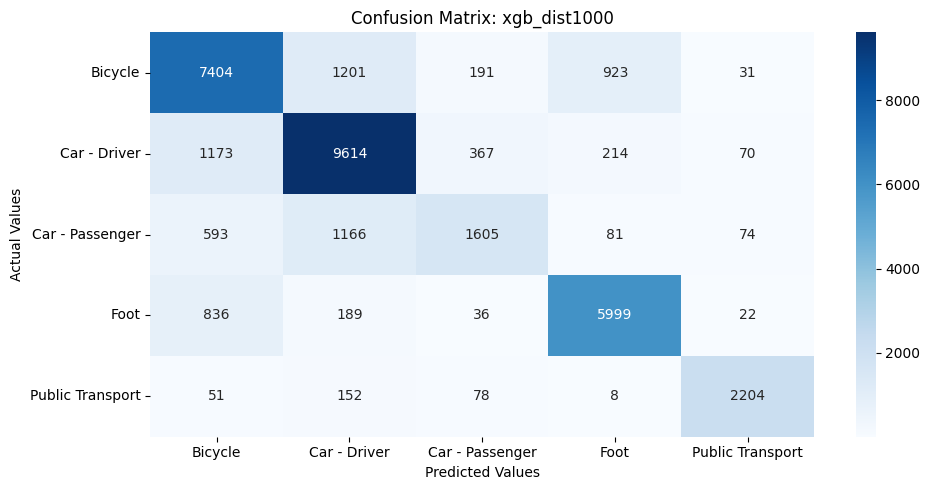

In [58]:
def conf_matrix(y_true, y_pred, title, ax):
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=mapping.keys(), columns=mapping.keys())
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Actual Values')
    ax.set_xlabel('Predicted Values')
    

fig, axes = plt.subplots(1, 1, figsize=(10, 5)) 

conf_matrix(y_test, y_pred_xgb_10000, title="Confusion Matrix: xgb_dist1000", ax=axes)  
plt.tight_layout()  
plt.savefig("confusion_matrices_dist10000.pdf")
plt.show()


In [60]:
combined_metrics_spatial = pd.concat([combined_metrics_df_knn, combined_metrics_df_rf,combined_metrics_df_xgb, combined_metrics_df_tabnet], axis=1)
combined_metrics_spatial.to_csv("combined_metrics_spatial.csv")
combined_metrics_spatial.T

,Precision (Macro),Recall (Macro),F1-score (Macro),Balanced Accuracy,Log Loss
KNN Rook,73.76%,56.47%,57.96%,56.47%,0.9117440860445595
KNN KNN8,73.73%,57.21%,58.73%,57.21%,0.9028393960479246
KNN dist10000,73.89%,57.15%,58.71%,57.15%,0.8990080862772643
Random Forest Rook,78.03%,73.74%,74.95%,73.74%,0.613405
Random Forest KNN8,78.4%,73.77%,74.96%,73.77%,0.591361
Random Forest dist10000,78.18%,73.47%,74.86%,73.47%,0.602151
XGBoost Rook,79.27%,75.58%,76.8%,75.58%,0.543022
XGBoost KNN8,79.28%,75.61%,76.81%,75.61%,0.542075
XGBoost dist10000,79.39%,75.74%,77.0%,75.74%,0.539766
TabNet Rook,76.5%,71.65%,73.32%,71.65%,0.628897


<a id='section9'></a>
# # Province analysis (error count)
[Back to Table of Contents](#Table-of-Contents)

In [79]:
# Load provinces data
provinces = pd.read_csv("X_test_region.csv")
provinces = provinces[["ResidentialProvince"]]

# Load predictions
y_pred = pd.DataFrame(y_pred_xgb_10000)
y_pred.rename(columns={0: "y_pred"}, inplace=True)
predicted_probs = pd.DataFrame(y_pred_prob_xgb_10000)

# y_test
y_test = pd.DataFrame(y_test)
y_test.rename(columns={0: "y_test"}, inplace=True)

# Combine the results
df_prediction = pd.concat([provinces, y_test, y_pred, predicted_probs], axis=1)

In [80]:
observations_per_region = df_prediction.groupby('ResidentialProvince').size().reset_index(name='observations_per_region')
df_prediction = pd.merge(df_prediction, observations_per_region, on='ResidentialProvince', how='left')

# count number of incorrect classified per province per mdoe 
df_prediction['is_class1'] = (df_prediction["y_test"] == 1) & (df_prediction["y_pred"] != 1)
df_prediction['is_class2'] = (df_prediction["y_test"] == 2) & (df_prediction["y_pred"] != 2)
df_prediction['is_class3'] = (df_prediction["y_test"] == 3) & (df_prediction["y_pred"] != 3)
df_prediction['is_class4'] = (df_prediction["y_test"] == 4) & (df_prediction["y_pred"] != 4)
df_prediction['is_class0'] = (df_prediction["y_test"] == 0) & (df_prediction["y_pred"] != 0)


incorrect_class1_counts = df_prediction.groupby('ResidentialProvince')['is_class1'].sum()
incorrect_class0_counts = df_prediction.groupby('ResidentialProvince')['is_class0'].sum()
incorrect_class2_counts = df_prediction.groupby('ResidentialProvince')['is_class2'].sum()
incorrect_class3_counts = df_prediction.groupby('ResidentialProvince')['is_class3'].sum()
incorrect_class4_counts = df_prediction.groupby('ResidentialProvince')['is_class4'].sum()


incorrect_counts_df = pd.DataFrame({
    'incorrect_class1_counts': incorrect_class1_counts,
    'incorrect_class0_counts': incorrect_class0_counts,
    'incorrect_class2_counts': incorrect_class2_counts,
    'incorrect_class3_counts': incorrect_class3_counts,
    'incorrect_class4_counts': incorrect_class4_counts
}).reset_index()
df_prediction_per_mode = pd.merge(df_prediction, incorrect_counts_df, on='ResidentialProvince', how='left')
df_prediction_per_mode.drop_duplicates("ResidentialProvince", inplace=True)

df_prediction_per_mode = df_prediction_per_mode[["ResidentialProvince", "incorrect_class1_counts", 'incorrect_class0_counts','incorrect_class2_counts','incorrect_class3_counts',
                        'incorrect_class4_counts', "observations_per_region"]]


df_prediction_per_mode.rename(columns = {"incorrect_class1_counts":'Car - Driver', 'incorrect_class0_counts':'Bicycle',
                                         'incorrect_class2_counts':'Car - Passenger', 
                                         'incorrect_class3_counts':'Foot', 'incorrect_class4_counts':"Public Transport" }, inplace = True)

# add % wrong predicted
df_prediction_per_mode['%_Car_Driver'] = round((df_prediction_per_mode['Car - Driver'] / df_prediction_per_mode['observations_per_region']) * 100,2)
df_prediction_per_mode['%_Bicycle'] = round((df_prediction_per_mode['Bicycle'] / df_prediction_per_mode['observations_per_region']) * 100,2)
df_prediction_per_mode['%_Car_Passenger'] = round((df_prediction_per_mode['Car - Passenger'] / df_prediction_per_mode['observations_per_region']) * 100,2)
df_prediction_per_mode['%_Foot'] = round((df_prediction_per_mode['Foot'] / df_prediction_per_mode['observations_per_region']) * 100,2)
df_prediction_per_mode['%_Public_Transportr'] = round((df_prediction_per_mode['Public Transport'] / df_prediction_per_mode['observations_per_region']) * 100,2)

df_prediction_per_mode.columns = ['ResidentialProvince', 'Wrong Predicted Car - Driver', 'Wrong Predicted Bicycle', 
    'Wrong Predicted Car - Passenger',  'Wrong Predicted Foot',   'Wrong Predicted Public Transport', 
    'Total Observations per Region',   '% of Wrong Predicted Car - Driver',   '% of Wrong Predicted Bicycle', 
    '% of Wrong Predicted Car - Passenger',  '% of Wrong Predicted Foot', '% of Wrong Predicted Public Transport']

df_prediction_per_mode.to_csv("df_prediction_per_mode.csv")
df_prediction_per_mode

,ResidentialProvince,Wrong Predicted Car - Driver,Wrong Predicted Bicycle,Wrong Predicted Car - Passenger,Wrong Predicted Foot,Wrong Predicted Public Transport,Total Observations per Region,% of Wrong Predicted Car - Driver,% of Wrong Predicted Bicycle,% of Wrong Predicted Car - Passenger,% of Wrong Predicted Foot,% of Wrong Predicted Public Transport
0,Fryslân,89,74,68,43,12,1180,7.54,6.27,5.76,3.64,1.02
6,Noord-Holland,252,273,232,121,32,3929,6.41,6.95,5.90,3.08,0.81
8,Noord-Brabant,250,339,318,119,41,4672,5.35,7.26,6.81,2.55,0.88
10,Zuid-Holland,176,306,207,128,47,4127,4.26,7.41,5.02,3.10,1.14
23,Overijssel,82,79,64,47,3,1416,5.79,5.58,4.52,3.32,0.21
25,Utrecht,363,441,301,213,46,6294,5.77,7.01,4.78,3.38,0.73
27,Limburg,102,195,166,107,27,2898,3.52,6.73,5.73,3.69,0.93
51,Gelderland,304,393,292,151,49,5249,5.79,7.49,5.56,2.88,0.93
56,Flevoland,24,39,49,31,0,721,3.33,5.41,6.80,4.30,0.00
187,Drenthe,22,20,19,11,1,538,4.09,3.72,3.53,2.04,0.19


In [73]:
df_prediction_per_mode.set_index('ResidentialProvince', inplace=True)
df_prediction_per_mode.corr()

,Car - Driver,Bicycle,Car - Passenger,Foot,Public Transport
Car - Driver,1.000000,0.963017,0.936610,0.943949,0.892803
Bicycle,0.963017,1.000000,0.950997,0.963430,0.958459
Car - Passenger,0.936610,0.950997,1.000000,0.921702,0.940321
Foot,0.943949,0.963430,0.921702,1.000000,0.923023
Public Transport,0.892803,0.958459,0.940321,0.923023,1.000000


In [62]:
# Count the number of observations per region
observations_per_region = df_prediction.groupby('ResidentialProvince').size().reset_index(name='observations_per_region')
df_prediction = pd.merge(df_prediction, observations_per_region, on='ResidentialProvince', how='left')


# is the prediction correct? 
df_prediction['is_correct'] = (df_prediction['y_test'] != df_prediction['y_pred'])

# Count wrong prediction per province
wrong_per_region = df_prediction.groupby('ResidentialProvince')['is_correct'].sum().reset_index(name='wrong_observations_per_region')

# Merge the counts back into the original DataFrame
df_prediction = pd.merge(df_prediction, wrong_per_region, on='ResidentialProvince', how='left')

# Calculate the percentage of wrong predictions per region
df_prediction['wrong_predictions_percentage'] = round((df_prediction['wrong_observations_per_region'] / df_prediction['observations_per_region']) * 100,2)

In [63]:
# sum probabilities across all classes
df_prediction['aggregated_prob'] = df_prediction[[0, 1, 2, 3, 4]].mean(axis=1)

# calculate standard error for aggregated probabilities within each region
df_prediction['se'] = np.sqrt(df_prediction['aggregated_prob'] * (1 - df_prediction['aggregated_prob']) / df_prediction['observations_per_region'])

# determine confidence level
confidence_level = 0.95

#  z-score for ci
z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)

# margin error
df_prediction['margin_of_error'] = z_score * df_prediction['se']

#  upper and lower bounds of the confidence interval for aggregated probabilities within each region
df_prediction['lower_ci'] = df_prediction['aggregated_prob'] - df_prediction['margin_of_error']
df_prediction['upper_ci'] = df_prediction['aggregated_prob'] + df_prediction['margin_of_error']


# extract relevant columns 
df_prediction = df_prediction[["ResidentialProvince", "observations_per_region", "wrong_observations_per_region", 'wrong_predictions_percentage', 
                              "se", "margin_of_error", 	"lower_ci", "upper_ci"]]
# drop duplicates provinces
df_prediction.drop_duplicates("ResidentialProvince", inplace=True)

# Save as df
df_prediction.to_csv("df_prediction_with_ci.csv", index=False)

In [70]:
df_prediction.rename(columns={"ResidentialProvince": "Province", "observations_per_region":"N.of Trips", 
                            "wrong_observations_per_region":"N.of Wrong Predicted Trips", 
                             "wrong_predictions_percentage": "% Predicted Wrong"}, inplace = True)
df_prediction

,Province,N.of Trips,N.of Wrong Predicted Trips,% Predicted Wrong,se,margin_of_error,lower_ci,upper_ci
0,Fryslân,1180,286,24.24,0.011644,0.022823,0.177177,0.222823
6,Noord-Holland,3929,910,23.16,0.006381,0.012507,0.187493,0.212507
8,Noord-Brabant,4672,1067,22.84,0.005852,0.011470,0.188530,0.211470
10,Zuid-Holland,4127,864,20.94,0.006226,0.012204,0.187796,0.212204
23,Overijssel,1416,275,19.42,0.010630,0.020834,0.179166,0.220834
25,Utrecht,6294,1364,21.67,0.005042,0.009882,0.190118,0.209882
27,Limburg,2898,597,20.60,0.007430,0.014563,0.185437,0.214563
51,Gelderland,5249,1189,22.65,0.005521,0.010821,0.189179,0.210821
56,Flevoland,721,143,19.83,0.014897,0.029197,0.170803,0.229197
187,Drenthe,538,73,13.57,0.017245,0.033800,0.166200,0.233800
